In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import os

# Ruta al directorio con las imágenes
directorio_imagenes = '/content/drive/My Drive/Proyecto de Grado G/ProcessedImages_Disc_Exp2'

imagenes_info = []
for filename in os.listdir(directorio_imagenes):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        base = filename.split('_')[0]
        id_paciente = base[3:-2]  # Extrae correctamente el ID del paciente
        tipo_ojo = base[-2:]
        full_path = os.path.join(directorio_imagenes, filename)
        imagenes_info.append({'filename': full_path, 'id': id_paciente, 'eye': tipo_ojo})

imagenes_df = pd.DataFrame(imagenes_info)

# Cargar y preparar los datos clínicos
data_od = pd.read_excel('/content/drive/My Drive/Proyecto de Grado G/patient_data_od.xlsx')
data_os = pd.read_excel('/content/drive/My Drive/Proyecto de Grado G/patient_data_os.xlsx')

data_od['id'] = data_od['Unnamed: 0'].str.replace('#', '').astype(str)
data_os['id'] = data_os['Unnamed: 0'].str.replace('#', '').astype(str)

data_od['eye'] = 'OD'
data_os['eye'] = 'OS'

data_clinica = pd.concat([data_od[['id', 'eye', 'Diagnosis']], data_os[['id', 'eye', 'Diagnosis']]])

full_df = pd.merge(imagenes_df, data_clinica, on=['id', 'eye'], how='left')
full_df = full_df[full_df['Diagnosis'] != 2]

dominant_diagnosis = full_df.groupby('id')['Diagnosis'].agg(lambda x: x.mode()[0])


patient_df = pd.DataFrame(dominant_diagnosis).reset_index()

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_patients, test_patients = next(splitter.split(patient_df, patient_df['Diagnosis']))

train_ids = patient_df.iloc[train_patients]['id']
test_ids = patient_df.iloc[test_patients]['id']

train_df = full_df[full_df['id'].isin(train_ids)]
test_df = full_df[full_df['id'].isin(test_ids)]

print("Train DataFrame:")
print(train_df[['filename', 'id', 'eye', 'Diagnosis']].head())

print("\nTest DataFrame:")
print(test_df[['filename', 'id', 'eye', 'Diagnosis']].head())

Train DataFrame:
                                             filename   id eye Diagnosis
2   /content/drive/My Drive/Proyecto de Grado G/Pr...  004  OD         1
3   /content/drive/My Drive/Proyecto de Grado G/Pr...  004  OS         1
4   /content/drive/My Drive/Proyecto de Grado G/Pr...  005  OD         1
5   /content/drive/My Drive/Proyecto de Grado G/Pr...  005  OS         1
14  /content/drive/My Drive/Proyecto de Grado G/Pr...  010  OD         1

Test DataFrame:
                                             filename   id eye Diagnosis
20  /content/drive/My Drive/Proyecto de Grado G/Pr...  015  OD         1
21  /content/drive/My Drive/Proyecto de Grado G/Pr...  015  OS         1
32  /content/drive/My Drive/Proyecto de Grado G/Pr...  023  OD         1
33  /content/drive/My Drive/Proyecto de Grado G/Pr...  023  OS         1
42  /content/drive/My Drive/Proyecto de Grado G/Pr...  028  OD         0


In [ ]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit


In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1.0 / 255,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1.0 / 255
)

In [ ]:
# Convierte la columna 'Diagnosis' a tipo cadena
train_df['Diagnosis'] = train_df['Diagnosis'].astype(str)
test_df['Diagnosis'] = test_df['Diagnosis'].astype(str)

train_data = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='Diagnosis',
    target_size=(299, 299),
    batch_size=20,
    class_mode='binary'
)

test_data = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='Diagnosis',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

valid_data = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='Diagnosis',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)


Found 335 validated image filenames belonging to 2 classes.
Found 84 validated image filenames belonging to 2 classes.
Found 84 validated image filenames belonging to 2 classes.


<ipython-input-5-1da293511785>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Diagnosis'] = train_df['Diagnosis'].astype(str)
<ipython-input-5-1da293511785>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Diagnosis'] = test_df['Diagnosis'].astype(str)


In [ ]:
input_tensor = Input(shape=(299, 299, 3))
base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False, pooling='avg')

x = base_model.output
x = Dense(2048, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

In [ ]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_auc', save_best_only=True, mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_auc', patience=20, restore_best_weights=True, mode='min')

history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=50,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 536ms/step - AUC: 0.9994 - accuracy: 0.9930 - loss: 0.0277 - val_AUC: 0.5680 - val_accuracy: 0.2143 - val_loss: 1.4213
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 413ms/step - AUC: 1.0000 - accuracy: 0.9993 - loss: 0.0106 - val_AUC: 0.6146 - val_accuracy: 0.3214 - val_loss: 0.9361
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 440ms/step - AUC: 1.0000 - accuracy: 0.9989 - loss: 0.0092 - val_AUC: 0.5132 - val_accuracy: 0.2381 - val_loss: 1.3441
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 545ms/step - AUC: 1.0000 - accuracy: 0.9942 - loss: 0.0116 - val_AUC: 0.5896 - val_accuracy: 0.2262 - val_loss: 1.1880
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 475ms/step - AUC: 0.9954 - accuracy: 0.9976 - loss: 0.0301 - val_AUC: 0.7015 - val_accuracy: 0.7024 - val_loss: 0.6326
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 424ms/step - AUC: 0.9994 - accuracy: 0.9920 - loss: 0.0310 - val_AUC: 0.5180 - val_accuracy: 0.4524 - val_loss: 0.7317
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 469ms/step - AUC: 1.0000 - accuracy: 0.9970 - loss: 0.0077 - val_AUC: 0.5711 - val_accuracy: 0.3571 - val_loss: 0.8599
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 514

In [ ]:
evaluation = model.evaluate(test_data)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}, Test AUC: {evaluation[2]}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - AUC: 0.7635 - accuracy: 0.7855 - loss: 0.6938
Test Loss: 0.5993267297744751, Test Accuracy: 0.7976190447807312, Test AUC: 0.8011412620544434


In [ ]:
y_train = train_data.classes

predictions_train = model.predict(train_data, steps=len(train_data), verbose=1)
predicted_classes_train = np.round(predictions_train).astype(int)
print(classification_report(y_train, predicted_classes_train, target_names=['Clase 0', 'Clase 1']))

auc_score_train = roc_auc_score(y_train, predictions_train)
print(f"AUC Score: {auc_score_train}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 471ms/step
Number of samples in y_train: 335
Number of predictions: 335
              precision    recall  f1-score   support

     Clase 0       0.80      0.87      0.83       265
     Clase 1       0.27      0.19      0.22        70

    accuracy                           0.73       335
   macro avg       0.54      0.53      0.53       335
weighted avg       0.69      0.73      0.71       335

AUC Score: 0.5040431266846361


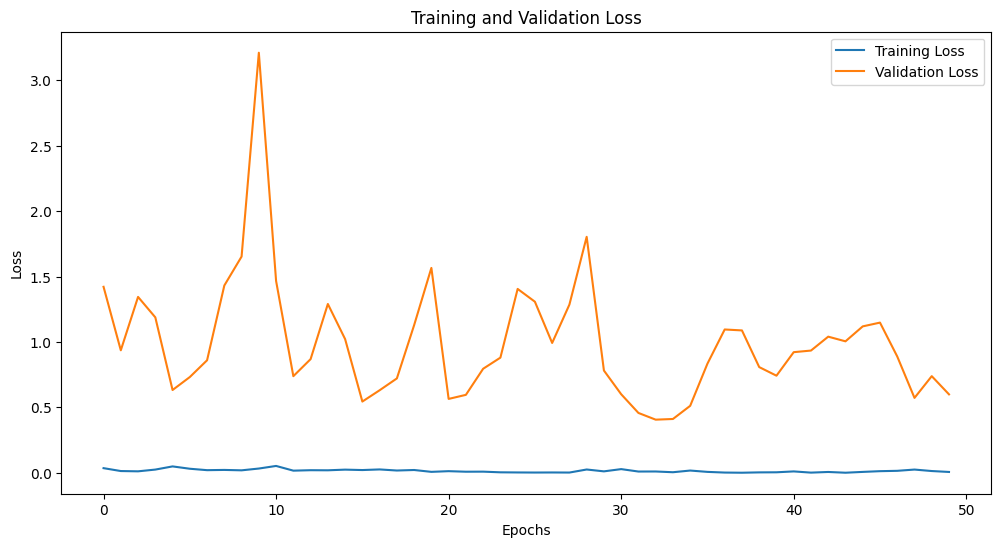

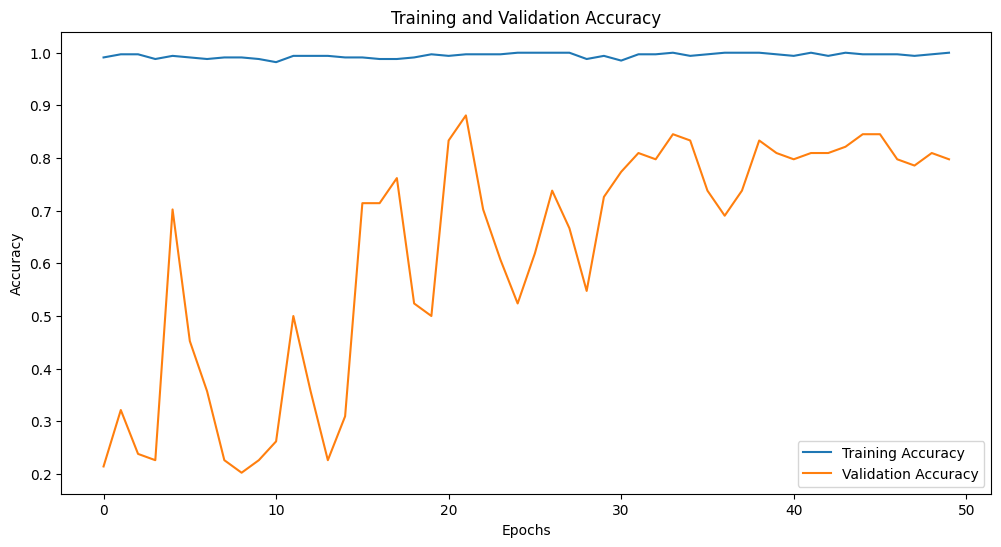

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

if 'accuracy' in history.history:
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
